## Web Page Classification

Classification of Web page content is vital to many tasks in Web information retrieval such as maintaining Web directories and focused crawling which is used to selectively seek out web pages that are relevant to a pre-defined set of topics.

### Why do we need Web Page Classification?

As an example, collecting and mining personal content on patients’ experiences with respect to disease symptoms and progression, treatment management, side effects and effectivenes can be very helpful in understanding a disease better.

The understanding attainable through mining this voluntarily contributed web content would be extremely expensive and time-consuming to capture via web queries. For example, a general query such as ‘breast cancer stories’ would pull up over 182 million results using Google web search.

However, if we can build an accurate classifier to pinpoint the right web pages that precisely contains patients' experiences using the URLs and page content, it can save a lot of time and compute for collecting this information.

## Problem Statement



In this case study, we are provided with URLs from 53000+ web pages. The objective is to build a classifier that can classify the web pages into their respective classes (Each web page can belong to only 1 class).

<img src="classifier.png" width=400 height=400>

Basically given the complete url, predict the tag a web page belongs to out of 9 predefined tags as given below:
* People profile
* Conferences/Congress
* Forums
* News article
* Clinical trials
* Publication
* Thesis
* Guidelines
* Others


## Data Description

The dataset contains the following features:
* web page_ID: Unique ID for the web page (1,2,3.... )
* Domain: Domain of the web page (Example: www.fiercepharma.com)
* Url: Complete URL of the web page (Example: http://www.fiercepharma.com/marketing/tecfidera-gilenya-and-aubagio-s-3-way-battle-for-ms-share-about-to-get-more-interesting)
* Tag: (Target) Tag (class) of the web page

The objective here is to predict the class of the web page from the above mentioned 9 classes.

#### Components of a URL
Let us have a look at each component of a URL to have better understanding of the data.

<img src="url_comp.png" width=600 height=600>

### Import Packages

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
from tqdm import tqdm
from urllib.parse import urlparse
pd.set_option("display.max_colwidth", 200)
import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_predict, GroupKFold
from sklearn.pipeline import FeatureUnion
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from scipy.sparse import hstack
%matplotlib inline

### Load Datasets

In [2]:
df = pd.read_csv("webpage data.csv")

### Basic Exploration

In [3]:
df.shape

(53229, 4)

In [4]:
df.head()

,Webpage_id,Domain,Url,Tag
0,1,www.fiercepharma.com,http://www.fiercepharma.com/marketing/tecfidera-gilenya-and-aubagio-s-3-way-battle-for-ms-share-about-to-get-more-interesting,news
1,2,www.fiercepharma.com,http://www.fiercepharma.com/pharma/novo-equipped-to-weather-storm-u-s-diabetes-market-ceo-says,news
2,3,www.fiercepharma.com,http://www.fiercepharma.com/pharma/another-exec-departs-troubled-endo-and-time-it-s-for-another-drugmaker,news
3,4,www.fiercepharma.com,http://www.fiercepharma.com/pharma/teva-buy-biosim-specialist-celltrion-it-wouldn-t-say-no,news
4,5,www.fiercepharma.com,http://www.fiercepharma.com/marketing/actress-marissa-tomei-partners-allergan-restasis-to-drive-dry-eye-awareness,news


In [5]:
df['Tag'].unique()

array(['news', 'clinicalTrials', 'conferences', 'profile', 'forum',
       'publication', 'thesis', 'guidelines', 'others'], dtype=object)

As mentioned in the problem statement, there are 9 separate categories. Let us have a look at a few samples from each category to hav

#### Public Profiles

In [6]:
df[df['Tag'] == 'profile'].head(2)

,Webpage_id,Domain,Url,Tag
3476,5096,www.healthcare4ppl.com,http://www.healthcare4ppl.com/physician/wisconsin/waukesha/andrew-v-beykovsky-1114036092.html,profile
3477,5097,www.healthcare4ppl.com,http://www.healthcare4ppl.com/physician/west-virginia/morgantown/clare-m-mcdaniel-1346231032.html,profile


#### Conferences/Congress

In [7]:
df[df['Tag'] == 'conferences'].head(2)

,Webpage_id,Domain,Url,Tag
550,1028,investors.alphatecspine.com,http://investors.alphatecspine.com/events.cfm,conferences
1033,1773,ir.alk.net,http://ir.alk.net/events.cfm,conferences


#### Forum

In [8]:
df[df['Tag'] == 'forum'].head(2)

,Webpage_id,Domain,Url,Tag
3689,5549,community.beatingbowelcancer.org,http://community.beatingbowelcancer.org/forum/926-post-op,forum
3765,5714,rollitup.org,http://rollitup.org/t/someguys-led-other-grows-2014-15-season.851562/page-82,forum


#### News Articles

In [9]:
df[df['Tag'] == 'news'].head(2)

,Webpage_id,Domain,Url,Tag
0,1,www.fiercepharma.com,http://www.fiercepharma.com/marketing/tecfidera-gilenya-and-aubagio-s-3-way-battle-for-ms-share-about-to-get-more-interesting,news
1,2,www.fiercepharma.com,http://www.fiercepharma.com/pharma/novo-equipped-to-weather-storm-u-s-diabetes-market-ceo-says,news


#### Clinical Trials

In [10]:
df[df['Tag'] == 'clinicalTrials'].head(2)

,Webpage_id,Domain,Url,Tag
30,36,upload.umin.ac.jp,https://upload.umin.ac.jp/cgi-open-bin/ctr_e/ctr_view.cgi?recptno=R000018186,clinicalTrials
31,39,upload.umin.ac.jp,https://upload.umin.ac.jp/cgi-open-bin/ctr_e/ctr_view.cgi?recptno=R000018428,clinicalTrials


#### Publications

In [11]:
df[df['Tag'] == 'publication'].head(2)

,Webpage_id,Domain,Url,Tag
4164,6295,jvi.asm.org,http://jvi.asm.org/content/87/9/4994.long,publication
4165,6296,iai.asm.org,http://iai.asm.org/content/77/7/3033.long,publication


#### Thesis

In [12]:
df[df['Tag'] == 'thesis'].head(2)

,Webpage_id,Domain,Url,Tag
5118,7526,ecommons.cornell.edu,https://ecommons.cornell.edu/handle/1813/29484,thesis
5119,7527,ecommons.cornell.edu,https://ecommons.cornell.edu/handle/1813/11185,thesis


#### Guidelines

In [13]:
df[df['Tag'] == 'guidelines'].head(2)

,Webpage_id,Domain,Url,Tag
6954,10201,www.nice.org.uk,https://www.nice.org.uk/guidance/indevelopment/gid-ta10173,guidelines
6955,10203,www.nice.org.uk,https://www.nice.org.uk/guidance/indevelopment/gid-ng10073,guidelines


#### Others

In [14]:
df[df['Tag'] == 'others'].head(2)

,Webpage_id,Domain,Url,Tag
6970,10229,joannabriggs.org,http://joannabriggs.org/,others
7152,10679,www.copdx.org.au,http://copdx.org.au/,others


* Looking at the samples, we can see that there are a few words in the URLs that are appearing consistently for each category. For example: there is the word forum for URLs of tag forum, gid for the URLs of tag guidelines and cfm for conferences. 
* This implies that it would be a good idea to actually find out the frequency of each word and use that as a feature

### Target Exploration

Let us look at the frequency distribution of all tags

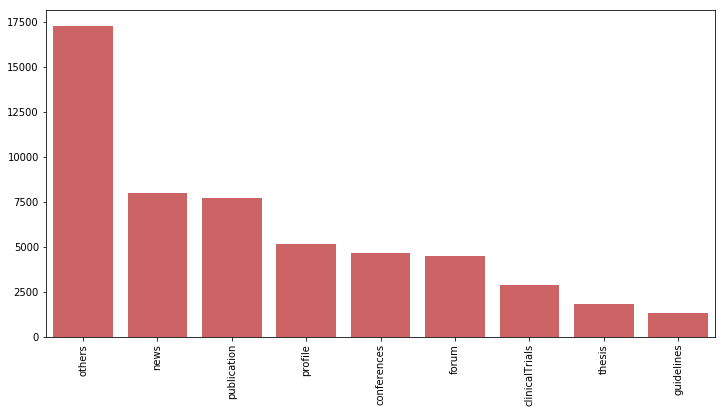

In [15]:
cnt_tag = df['Tag'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_tag.index, cnt_tag.values, alpha=0.8, color=color[3])
plt.xticks(rotation='vertical')
plt.show()

There are 2 major categories apart from others - news and publication. Public profiles, forums and conferences lie in the next bracket.

### Understanding the common words used in the URLs: WordCloud

Now I want to see how well the given sentiments are distributed across the train dataset. One way to accomplish this task is by understanding the common words by plotting wordclouds.

A wordcloud is a visualization wherein the most frequent words appear in large size and the less frequent words appear in smaller sizes.

Let’s visualize all the words our data using the wordcloud plot.

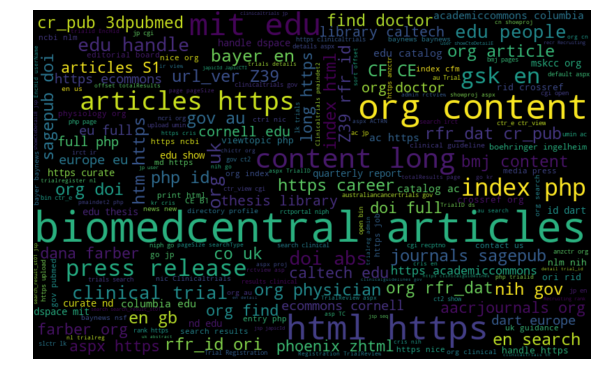

In [16]:
all_words = ' '.join([text for text in df['Url']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Overall, most of the URLs direct to healthcare pages as can be seen from the word cloud and there are words such as thesis, edu etc. which again imply that frequency of words should be an important feature for prediction.

Now, a good idea would be to create word clouds for each specific cateogry.

### Word Cloud for the tag - thesis

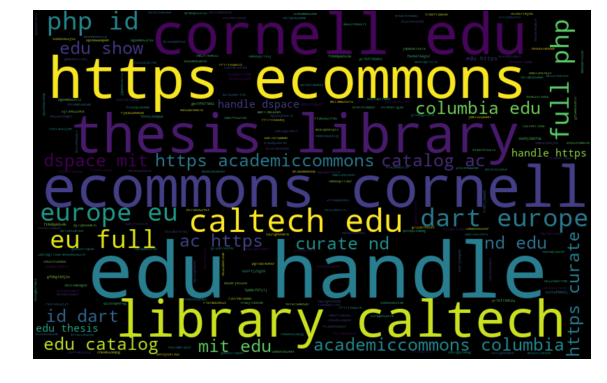

In [17]:
all_words = ' '.join([text for text in df[df['Tag'] == 'thesis']['Url']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Similarly, You can build word clouds for each category as well to get more idea of what the url looks like for each category.

### Feature Extraction
Here we simply have domain and URL and these are neither numeric nor categorical variable as each URL is unique. 

Here as learnt in the NLP module, we would need to extract information from text to create features and build a classifier.

The URLs in the dataset can be considered as a single string since the words in the URL have no spaces. Instead, there are 2 types of separators here '/' and '-'. We can replace these by spaces and we can get individual words this way.

In [18]:
def clean_url(df):
    df["Url"] = df["Url"].str.replace("/", " ")
    df["Url"] = df["Url"].str.replace("-", " ")
    df["Url"] = df["Url"].str.replace("https:", "")
    df["Url"] = df["Url"].str.replace("http:", "")
    return df

In [19]:
df = clean_url(df)

In [20]:
df.head(5)

,Webpage_id,Domain,Url,Tag
0,1,www.fiercepharma.com,www.fiercepharma.com marketing tecfidera gilenya and aubagio s 3 way battle for ms share about to get more interesting,news
1,2,www.fiercepharma.com,www.fiercepharma.com pharma novo equipped to weather storm u s diabetes market ceo says,news
2,3,www.fiercepharma.com,www.fiercepharma.com pharma another exec departs troubled endo and time it s for another drugmaker,news
3,4,www.fiercepharma.com,www.fiercepharma.com pharma teva buy biosim specialist celltrion it wouldn t say no,news
4,5,www.fiercepharma.com,www.fiercepharma.com marketing actress marissa tomei partners allergan restasis to drive dry eye awareness,news


### Feature Extraction

Now, that we have tokenised the words and done necessary cleaning. It is time to convert these to features. In the NLP module, we learned about various techniques:
* Bag of Words
* TFIDF (Term Frequency Inverse Document Frequency)
* Word Vectors

Here, we will demonstrate BOW features and TFIDF features. Sklearn provides functionality for both. 

Let's use that to create these features.

### Bag-of-Words Features

The URL has has lot of abbreviations and for the same words so it could be a good idea to use create bag of word features from characters as well.

<img src = "image 2.png">

In [21]:
# Word and character BOW on URLs
vec_bow = CountVectorizer(ngram_range=(1, 3), min_df=400)
vec_bow.fit(df['Url'])
Url_bow = vec_bow.transform(df['Url'])

If you look at the documentation for Sklearn feature extraction, you will see that:
* ngram_range helps to define the range of n for the ngrams
* When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold min_df

## Model Building
This is a multi-class classification problem and the metric that we will use here is weighted F1-Score. As discussed in the multi-class module, weighted F1 score basically assigns weights proportional to the class frequency in the train set.

## Train Test Split

Randomly spliting the dataset into train and test and checking performance will not be correct for this problem. Here's why:

Let's say we have a domain ecommons.cornell.edu. This is basically Cornell University's digital repository and predominantly contain thesis class. Now, if this domain (ecommons.cornell.edu) and class (thesis) combination are contained in both train and test. Just on the basis of domain I can predict the class to be thesis but this model would not be useful and would not generalise well on let's say new thesis by a different domain.

The Solution?


The train and test data split should done based on Domain-Tag combination, such that no 2 URLs for the same class and domain are kept in the train and test respectively because in that case domain can be directly mapped to the tag and that would be a leakage.


## Model Validation

For implementing the above logic. We will use Group K-Fold from Sklearn. In group K-Fold, the same group will not appear in two different folds. The folds are approximately balanced in the sense that the number of distinct groups is approximately the same in each fold.

In [ ]:
# Replicate train/test split strategy for cross validation
df["target_str"] = df["Domain"].astype(str) + '_' + df["Tag"].astype(str)
# cvlist = list(GroupKFold(5).split(df, groups=df["target_str"]))

In [ ]:
df["target_str"].head()

In [ ]:
cvlist

#### Convert tags from strings to numbers

In [ ]:
X = Url_bow

TAG_DICT = {"others":1, "news": 2, "publication":3, "profile": 4,
            "conferences": 5, "forum": 6, "clinicalTrials": 7,
            "thesis": 8, "guidelines": 9}

df['target'] = df.Tag.map(TAG_DICT)
y = df["target"].values

In [ ]:
def cv_score(ml_model, df):
    i = 1
    cv_scores = []
    X = df
    
    # Custom Cross validation based on group KFold
    for df_index,test_index in cvlist:
        print('\n{} of Group kfold {}'.format(i,5))
        xtr,xvl = X[df_index],X[test_index]
        ytr,yvl = y[df_index],y[test_index]
            
        # Define model for fitting on the training set for each fold
        model = ml_model
        model.fit(xtr, ytr)
        pred_probs = model.predict_proba(xvl)
        label_preds = np.argmax(pred_probs, axis=1) + 1
        
        # Calculate scores for each fold and print
        score = f1_score(yvl, label_preds, average="weighted")
        sufix = ""
        msg = ""
        msg += "Weighted F1 Score: {}".format(score)
        print("{}".format(msg))
         
         # Save scores
        cv_scores.append(score)
        i+=1
    return cv_scores

### Naive Bayes

In [ ]:
cv_score(MultinomialNB(alpha=.01), Url_bow)

### Character N-Grams

These scores are low. Since, the URLs are not regular sentences. It would be a good idea to also build features using character ngrams as well. 

For sequences of characters, the 3-grams that can be generated from "good morning" are "goo", "ood", "od ", "d m", " mo", "mor"

Let's do that and check performance again.

In [ ]:
# Word and character BOW on URLs
vec1 = CountVectorizer(analyzer='char', ngram_range=(1, 5), min_df=500)
vec2 = CountVectorizer(analyzer='word', ngram_range=(1, 3), min_df=400)
vec_bow = FeatureUnion([("char", vec1), ("word", vec2)])
vec_bow.fit(df['Url'])
Url_bow = vec_bow.transform(df['Url'])

In [ ]:
cv_score(MultinomialNB(alpha=.01), Url_bow)

We see significant improvement by using the character N-Grams. Now, lets try the TFIDF features

### TFIDF Features

In [ ]:
# Word and character TFIDF on URLs
vec1 = TfidfVectorizer(analyzer='char', ngram_range=(1, 5), min_df=500)
vec2 = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=400)
vec_tfidf = FeatureUnion([("char", vec1), ("word", vec2)])
vec_tfidf.fit(df['Url'])
Url_tfidf = vec_tfidf.transform(df['Url'])

In [ ]:
nb = cv_score(MultinomialNB(alpha=.01), Url_tfidf)

### Logistic Regression

We are getting better performance from TFIDF features. Let's go with that and try logistic regression now. Here, I have used class weight as balanced. This specifically changes the weights of samples inversely proportional to theit frequency meaning the classes which have less number of samples will have more weight.

In [ ]:
log_reg = cv_score(LogisticRegression(C=0.1,class_weight="balanced"), Url_tfidf)

### Tree Based Methods

Next, we will try tree based methods to check performance.

### Decision Tree

In [ ]:
dtree = cv_score(DecisionTreeClassifier(min_samples_leaf=25, min_samples_split=25), Url_tfidf)

### Random Forest

In [ ]:
rf_params = {'random_state': 0, 'n_jobs': -1, 'n_estimators': 100, 'max_depth': 50, 'n_jobs': -1}
rf = cv_score(RandomForestClassifier(**rf_params), Url_tfidf)

In [ ]:
results_df = pd.DataFrame({'Random Forest':rf, 'Decision Tree': dtree, 'Logistic Regression': log_reg, 'Naive Bayes':nb})
results_df.plot(y=["Random Forest", "Decision Tree","Logistic Regression","Naive Bayes"], kind="bar")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Conclusions
* Logistic Regression is getting the best performance.
* Interestingly Tree Based methods are performing badly.
* The scores are not very stable due to the large number of classes and few samples